# Airbus Ship Detection Challenge

- Dataset can be found [here](https://www.kaggle.com/c/airbus-ship-detection/data).

- The goal of the project is to build a segmentation model to locate ships in images.

In [2]:
import os
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from skimage.measure import label, regionprops
from sklearn.model_selection import StratifiedShuffleSplit
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

DATA_DIR = 'data/'
WORK_DIR = 'data/'
# DATA_DIR = '/kaggle/input/airbus-ship-detection/'
# WORK_DIR = '/kaggle/working/'

IMAGE_DATA_DIR = os.path.join(DATA_DIR, 'train_v2')
MASKS_CACHE_DIR = os.path.join(WORK_DIR, 'masks_cache')
RAND_SEED = 42
SUBSET_SIZE = 0.03
IMAGE_SIZE = (768, 768)

plt.style.use('dark_background')

np.random.seed(RAND_SEED)
tf.keras.utils.set_random_seed(RAND_SEED)
# tf.config.experimental.enable_op_determinism()    

# Check/create directories
if not os.path.exists(WORK_DIR):
    os.makedirs(WORK_DIR)
    print(f"Directory '{WORK_DIR}' created")
else:
    print(f"Directory '{WORK_DIR}' already exists")

if not os.path.exists(MASKS_CACHE_DIR):
    os.makedirs(MASKS_CACHE_DIR)
    print(f"Directory '{MASKS_CACHE_DIR}' created")
else:
    print(f"Directory '{MASKS_CACHE_DIR}' already exists")

In [3]:
df_truth = pd.read_csv(os.path.join(DATA_DIR, 'train_ship_segmentations_v2.csv'))
df_truth

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
...,...,...
231718,fffedbb6b.jpg,NaN
231719,ffff2aa57.jpg,NaN
231720,ffff6e525.jpg,NaN
231721,ffffc50b4.jpg,NaN


## EDA

In [4]:
def get_and_display_image(image_path):
    with Image.open(image_path) as img:
        plt.imshow(img)
        plt.axis('off')  # Hide the axis
        plt.show()
        
    return img

In [5]:
display(df_truth.info(), df_truth.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231723 entries, 0 to 231722
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   ImageId        231723 non-null  object
 1   EncodedPixels  81723 non-null   object
dtypes: object(2)
memory usage: 3.5+ MB


None

,ImageId,EncodedPixels
count,231723,81723
unique,192556,81722
top,e6fd0c12e.jpg,43801 1 44567 4 45334 5 46100 8 46867 9 47636 ...
freq,15,2


Let's investigate discrepancies in `count/unique`.

We'll take a look at `EncodedPixels` first.

In [6]:
dup_pixels = df_truth.EncodedPixels.value_counts().index[0]
image_ids = df_truth[df_truth['EncodedPixels'] == dup_pixels]['ImageId']
image_ids

52192     3a082cd94.jpg
158723    af41002a2.jpg
Name: ImageId, dtype: object

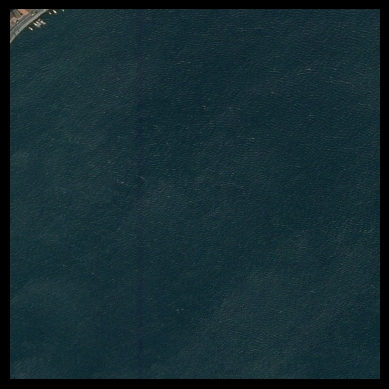

(768, 768)


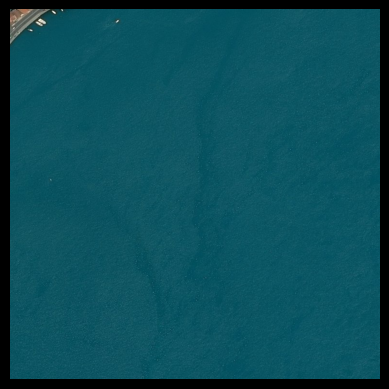

(768, 768)


In [7]:
image0 = get_and_display_image(os.path.join(IMAGE_DATA_DIR, image_ids.iloc[0]))
print(image0.size)

image1 = get_and_display_image(os.path.join(IMAGE_DATA_DIR, image_ids.iloc[1]))
print(image1.size)

Let's check `ImageId`'s.

In [8]:
df_truth.ImageId.value_counts()

ImageId
e6fd0c12e.jpg    15
2053a78bd.jpg    15
d3c47b3d3.jpg    15
4de149bd9.jpg    15
c8e722430.jpg    15
                 ..
591ab2331.jpg     1
591af2fb2.jpg     1
591afc23d.jpg     1
591b2dd30.jpg     1
ffffe97f3.jpg     1
Name: count, Length: 192556, dtype: int64

In [9]:
eda_image_ids = ['e6fd0c12e.jpg', '2053a78bd.jpg', 'd3c47b3d3.jpg', '4de149bd9.jpg', 'c8e722430.jpg']
df_truth[df_truth['ImageId'].isin(eda_image_ids)]

,ImageId,EncodedPixels
29048,2053a78bd.jpg,154445 2 155211 5 155978 6 156747 6 157515 6 1...
29049,2053a78bd.jpg,139105 1 139871 3 140638 5 141406 5 142175 5 1...
29050,2053a78bd.jpg,166051 4 166819 8 167587 8 168354 9 169122 8 1...
29051,2053a78bd.jpg,136060 2 136828 4 137595 5 138363 5 139130 5 1...
29052,2053a78bd.jpg,150576 5 151344 5 152112 5 152880 4 153650 2
...,...,...
208982,e6fd0c12e.jpg,544963 3 545731 3 546498 4 547266 3 548034 3 5...
208983,e6fd0c12e.jpg,578761 2 579528 3 580296 2 581064 2 581831 3 5...
208984,e6fd0c12e.jpg,522719 2 523485 4 524251 7 525018 7 525787 5 5...
208985,e6fd0c12e.jpg,516570 1 517337 3 518104 3 518872 2 519639 1 5...


Looks like images with multiple ships(`EncodedPixels` entries) were added to the dataset separately, but under the same `ImageId`.

Let's see how many there are.

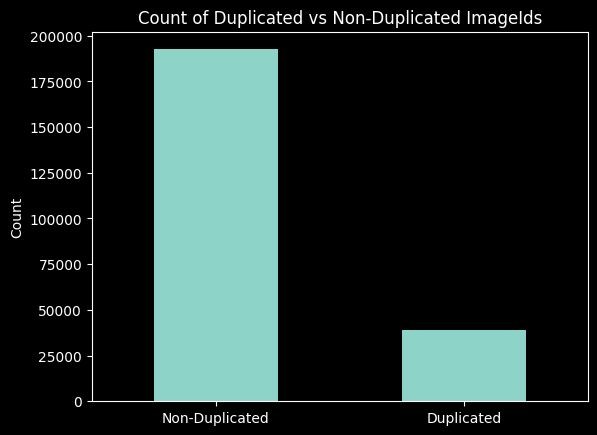

Non-Duplicated    192556
Duplicated         39167
Name: count, dtype: int64


In [10]:
# Counting the duplicated and non-duplicated ImageIds
dup_series = df_truth.duplicated('ImageId')
dup_counts = dup_series.value_counts()

# Renaming the index for better clarity on the plot
dup_counts.index = ['Non-Duplicated', 'Duplicated']

# Plotting the bar plot
dup_counts.plot(kind='bar')
plt.title('Count of Duplicated vs Non-Duplicated ImageIds')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Rotate x-axis labels to show horizontal text
plt.show()

print(dup_counts)

total_duplicated = dup_counts['Duplicated']

Let's aggregate `EncodedPixels` of "duplicates" by `ImageId`.

In [11]:
# Group by ImageId and concatenate EncodedPixels
join_not_na = lambda x: ' '.join(x) if x.notna().any() else np.nan
df_grouped = df_truth.groupby('ImageId')['EncodedPixels'].apply(join_not_na).reset_index()

df_grouped

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,0001b1832.jpg,NaN
...,...,...
192551,fffedbb6b.jpg,NaN
192552,ffff2aa57.jpg,NaN
192553,ffff6e525.jpg,NaN
192554,ffffc50b4.jpg,NaN


In [12]:
sanity_check_series = pd.Series({
    "len(df_truth)": len(df_truth),
    "total_duplicated": total_duplicated,
    "len(df_truth) - total_duplicated": len(df_truth) - total_duplicated,
    "len(df_grouped)": len(df_grouped)
})

sanity_check_series

len(df_truth)                       231723
total_duplicated                     39167
len(df_truth) - total_duplicated    192556
len(df_grouped)                     192556
dtype: int64

Presence of data in `EncodedPixels` column indicates the presence of ships in the image.

Let's check our class distribution.

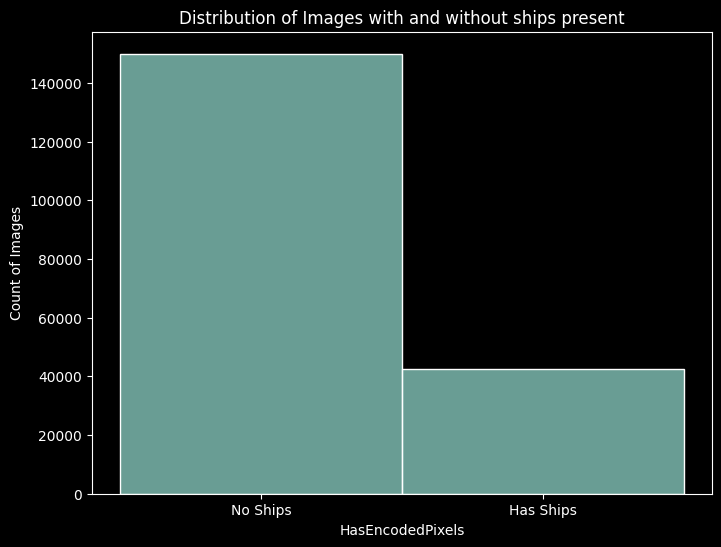

HasEncodedPixels
False    150000
True      42556
Name: count, dtype: int64

HasEncodedPixels
False    0.778994
True     0.221006
Name: count, dtype: float64

In [13]:
# Create a new column indicating whether 'EncodedPixels' is empty or not
df_grouped['HasEncodedPixels'] = df_grouped['EncodedPixels'].apply(lambda x: not pd.isna(x) and x.strip() != "")

# Plotting the distribution of images with and without ships
plt.figure(figsize=(8, 6))
sns.histplot(df_grouped['HasEncodedPixels'], bins=[-0.5, 0.5, 1.5], kde=False)
plt.xticks([0, 1], ['No Ships', 'Has Ships'])
plt.ylabel('Count of Images')
plt.title('Distribution of Images with and without ships present')
plt.show()

class_distribution_grouped = df_grouped.HasEncodedPixels.value_counts()
display(class_distribution_grouped, class_distribution_grouped/len(df_grouped))

In [14]:
# each image already has a lot of "non ship" space, tried training without dropping as well
df_grouped = df_grouped.dropna(subset=['EncodedPixels'])
df_grouped

,ImageId,EncodedPixels,HasEncodedPixels
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...,True
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...,True
5,00021ddc3.jpg,108287 1 109054 3 109821 4 110588 5 111356 5 1...,True
6,0002756f7.jpg,255784 2 256552 4 257319 7 258087 9 258854 12 ...,True
9,00031f145.jpg,340363 1 341129 4 341896 6 342663 7 343429 10 ...,True
...,...,...,...
192524,fff77c602.jpg,133056 1 133823 4 134591 6 135358 8 136126 10 ...,True
192528,fff909871.jpg,441057 2 441825 4 442592 7 443360 9 444128 11 ...,True
192543,fffcb6464.jpg,222782 4 223550 10 224318 14 225086 14 225854 ...,True
192546,fffd924fb.jpg,110011 5 110779 5 111547 5 112315 5 113083 5 1...,True


Let's look at few images.

We'll check an image that contains ships.

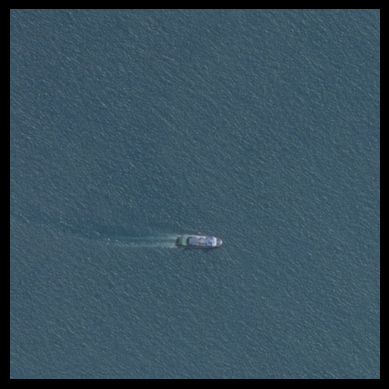

(768, 768)


In [15]:
eda_image_index = 2
eda_img_path = os.path.join(IMAGE_DATA_DIR, df_truth.ImageId[eda_image_index])

eda_img = get_and_display_image(eda_img_path)
print(eda_img.size)

Pixels are encoded in pairs of values that contain a start position and a run length. E.g. '1 3' implies starting at pixel 1 and running a total of 3 pixels (1,2,3).

For example, '1 3 10 5' implies pixels 1,2,3,10,11,12,13,14 are to be included in the mask. The pixels are one-indexed
and numbered from top to bottom, then left to right: 1 is pixel (1,1), 2 is pixel (2,1), etc. 

Images with no ships have a blank value in the `EncodedPixels` column.

In [16]:
# Get mask by decoding "run-length" EncodedPixels data
def get_mask_rle_decode(encoded_pixels, shape):
    s = encoded_pixels.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1  # Convert one-indexed to zero-indexed
    ends = starts + lengths
    mask = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        mask[lo:hi] = 1
        
    return mask.reshape(shape).T  # Need to transpose to align with the image shape


mask = get_mask_rle_decode(df_grouped.EncodedPixels[eda_image_index], eda_img.size)
np.count_nonzero(mask)

3388

Let's see how detected mask looks like

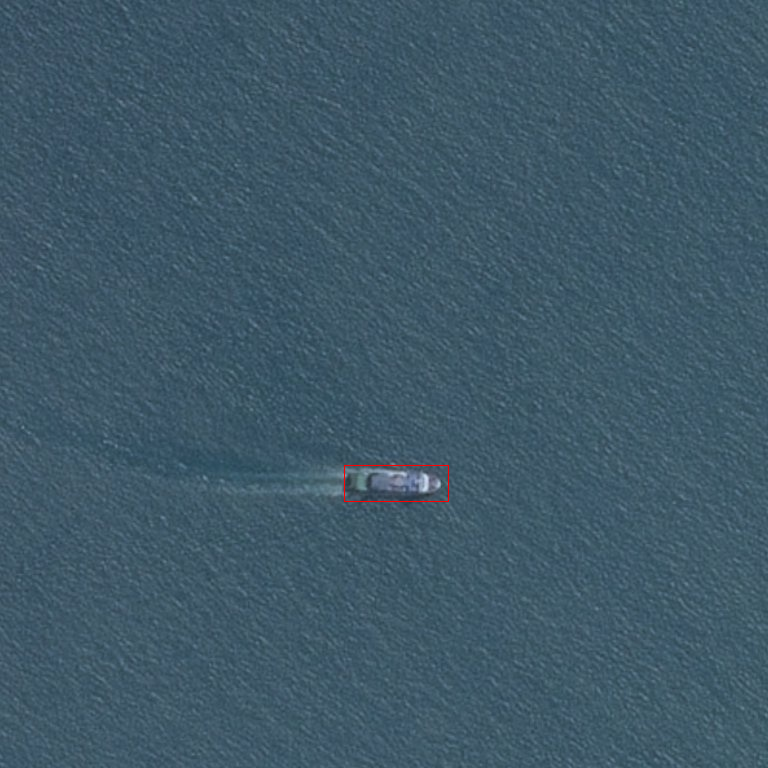

In [17]:
def draw_bounding_box(image, mask):
    # Convert mask to a boolean array
    mask_bool = mask.astype(bool)

    # Label connected regions of an integer array
    labeled_mask = label(mask_bool)

    # Create a copy of the image to draw on
    bbox_image = image.copy()

    # Find the bounding box of each ship area
    for region in regionprops(labeled_mask):
        minr, minc, maxr, maxc = region.bbox
        # Draw rectangle around segmented coins
        draw = ImageDraw.Draw(bbox_image)
        draw.rectangle(((minc, minr), (maxc, maxr)), outline='red')

    return bbox_image


draw_bounding_box(eda_img, mask)

Let's check image with multiple ships/`EncodedPixels`

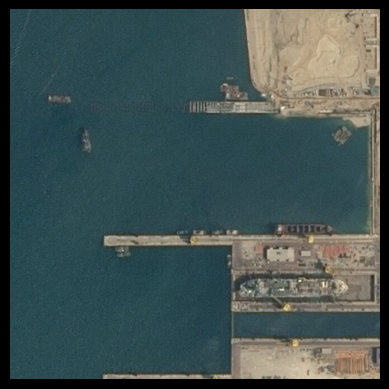

(768, 768)


In [18]:
eda_img2_path = os.path.join(IMAGE_DATA_DIR, eda_image_ids[3])

eda_img2 = get_and_display_image(eda_img2_path)
print(eda_img2.size)

9330


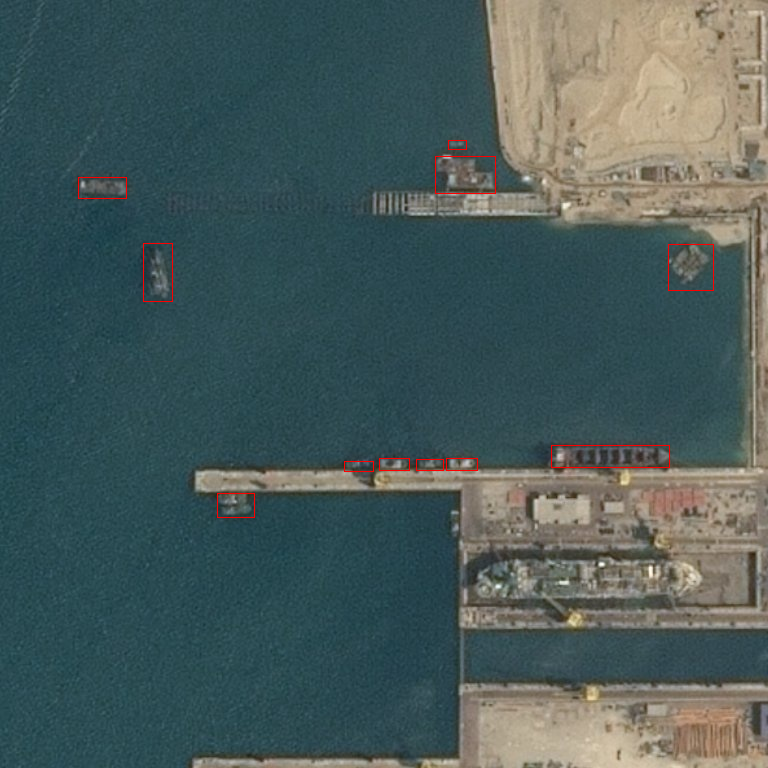

In [19]:
eda_image_index2 = df_grouped[df_grouped['ImageId'] == eda_image_ids[3]].index[0]
mask2 = get_mask_rle_decode(df_grouped.EncodedPixels[eda_image_index2], eda_img2.size)
print(np.count_nonzero(mask2))

draw_bounding_box(eda_img2, mask2)

## Split/preprocessing

Initial dataset is large, so we will create a subset for the task at hand and split `train/val/test`

In [20]:
# Split the dataset into subset and remaining dataset
sss_initial = StratifiedShuffleSplit(n_splits=1, test_size=1-SUBSET_SIZE, random_state=RAND_SEED)
for subset_index, _ in sss_initial.split(df_grouped, df_grouped['HasEncodedPixels']):
    df_subset = df_grouped.iloc[subset_index]

# Pre-fill column for mask file names
df_subset['MaskId'] = df_subset['ImageId'].apply(lambda x: (x.split('.')[0] + '.png'))

# Now we have a stratified subset, let's split it into train/val/test
fracs = {'train': 0.6, 'val': 0.2, 'test': 0.2}
train_size = fracs['train'] / (fracs['train'] + fracs['val'])
val_size = fracs['val'] / (fracs['val'] + fracs['test'])

# Split the subset dataset into training and remaining dataset (for val/test)
sss_train_val = StratifiedShuffleSplit(n_splits=1, test_size=1-train_size, random_state=RAND_SEED)
for train_index, temp_index in sss_train_val.split(df_subset, df_subset['HasEncodedPixels']):
    df_train = df_subset.iloc[train_index]
    df_temp = df_subset.iloc[temp_index]

# Use StratifiedShuffleSplit again for splitting the df_temp into validation and test sets
sss_val_test = StratifiedShuffleSplit(n_splits=1, test_size=1 - val_size, random_state=RAND_SEED)
for val_index, test_index in sss_val_test.split(df_temp, df_temp['HasEncodedPixels']):
    df_val = df_temp.iloc[val_index]
    df_test = df_temp.iloc[test_index]

# Now we have df_train, df_val, df_test with preserved class distribution
print(f'Total samples in subset: {len(df_subset)} ({SUBSET_SIZE*100:.1f}% of the original dataset)')
print(f'Training samples: {len(df_train)}')
print(f'Validation samples: {len(df_val)}')
print(f'Test samples: {len(df_test)}')

df_subset.head()

Total samples in subset: 1276 (3.0% of the original dataset)
Training samples: 956
Validation samples: 160
Test samples: 160


C:\Users\larki\AppData\Local\Temp\ipykernel_27028\3039598224.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['MaskId'] = df_subset['ImageId'].apply(lambda x: (x.split('.')[0] + '.png'))


,ImageId,EncodedPixels,HasEncodedPixels,MaskId
82294,6d4260870.jpg,440749 1 441516 3 442283 5 443050 6 443816 9 4...,True,6d4260870.png
158197,d28930287.jpg,429552 1 430318 4 431085 6 431852 7 432618 10 ...,True,d28930287.png
32168,2aba24f05.jpg,16193 2 16959 4 17726 6 18494 6 19263 5 20031 ...,True,2aba24f05.png
174334,e7da5dcb8.jpg,494777 1 495544 4 496312 5 497079 8 497846 11 ...,True,e7da5dcb8.png
90801,7896165ab.jpg,410768 2 411532 6 412296 11 413060 15 413824 1...,True,7896165ab.png


Let's pre-compute masks cache from `EncodedPixels` for our subset

In [22]:
for index, row in df_subset.iterrows():
    
    mask_file_path = os.path.join(MASKS_CACHE_DIR, row['MaskId'])
        
    # Check if the file already exists.
    if not os.path.exists(mask_file_path):
        # Check if the image has EncodedPixels/ships
        if row['HasEncodedPixels']:
            # Decode mask
            mask = get_mask_rle_decode(row['EncodedPixels'], shape=IMAGE_SIZE)
        # If there's no EncodedPixels/ships, create an array of zeroes.
        else:
            mask = np.zeros(IMAGE_SIZE, dtype=np.uint8)
        
        # Convert to an image and save
        mask_image = Image.fromarray(mask.astype('uint8'))
        mask_image.save(mask_file_path)

Let's check our sanity

In [23]:
file_count = len(os.listdir(MASKS_CACHE_DIR))
print(len(df_subset), file_count)

1276 1276


Let's build pipelines for images and masks

In [24]:
IMAGE_SIZE_TRAINING = int(IMAGE_SIZE[0]/4), int(IMAGE_SIZE[1]/4)
gen_args = dict(y_col=None,
                class_mode=None,
                batch_size=16,
                target_size=IMAGE_SIZE_TRAINING,
                seed=RAND_SEED)

datagen = ImageDataGenerator(rescale=1/255.)

def create_generator(df):
    # Create Image Data Generators for images and masks
    image_gen = datagen.flow_from_dataframe(
        dataframe=df,
        directory=IMAGE_DATA_DIR,
        x_col='ImageId',
        **gen_args)
    
    mask_gen = datagen.flow_from_dataframe(
        dataframe=df,
        directory=MASKS_CACHE_DIR,
        x_col='MaskId',
        color_mode='grayscale', # Masks are usually in grayscale
        **gen_args)
    
    return zip(image_gen, mask_gen)

train_gen = create_generator(df_train)
val_gen = create_generator(df_val)
test_gen = create_generator(df_test)

Found 956 validated image filenames.
Found 956 validated image filenames.
Found 160 validated image filenames.
Found 160 validated image filenames.
Found 160 validated image filenames.
Found 160 validated image filenames.


## Modeling/training

In [25]:
SMOOTH=1e-5

# Dice loss function
def dice_loss(y_true, y_pred, smooth=SMOOTH):
    
    return 1 - dice_coef(y_true, y_pred, smooth)


def dice_coef(y_true, y_pred, smooth=SMOOTH):
#     print("Runtime shapes:", tf.shape(y_true), tf.shape(y_pred))
    y_true_f = tf.cast(tf.reshape(y_true, [-1]),'float32')
    y_pred_f = tf.cast(tf.reshape(y_pred, [-1]),'float32')
#     print("Shapes before reshape:", y_true_f.shape, y_pred_f.shape)
    intersection = tf.reduce_sum(tf.math.multiply(y_true_f,y_pred_f))

    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

In [26]:
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization, Activation
from keras.models import Model, load_model, save_model
from keras.optimizers import Adam
from keras import backend as K

K.clear_session()

# from keras.mixed_precision import mixed_precision
# mixed_precision.set_global_policy('mixed_float16')

tf.keras.backend.set_floatx('float16')

def conv_block(input_tensor, num_filters):
    x = Conv2D(num_filters, (3, 3), padding='same', kernel_initializer='HeNormal')(input_tensor)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(num_filters, (3, 3), padding='same', kernel_initializer='HeNormal')(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    return x

def build_unet(input_shape):
    inputs = Input(shape=input_shape)

    # Encoder
    c1 = conv_block(inputs, 8)
    p1 = MaxPooling2D((2, 2))(c1)
    c2 = conv_block(p1, 16)
    p2 = MaxPooling2D((2, 2))(c2)
    c3 = conv_block(p2, 32)
    p3 = MaxPooling2D((2, 2))(c3)
#     c4 = conv_block(p3, 64)
#     p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    # Bridge
    c5 = conv_block(p3, 64)

    # Decoder
#     u6 = UpSampling2D((2, 2))(c5)
#     u6 = concatenate([u6, c4])
#     c6 = conv_block(u6, 64)
    u7 = UpSampling2D((2, 2))(c5)
    u7 = concatenate([u7, c3])
    c7 = conv_block(u7, 32)
    u8 = UpSampling2D((2, 2))(c7)
    u8 = concatenate([u8, c2])
    c8 = conv_block(u8, 16)
    u9 = UpSampling2D((2, 2))(c8)
    u9 = concatenate([u9, c1])
    c9 = conv_block(u9, 8)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model


input_shape = (*IMAGE_SIZE_TRAINING, 3)  # RGB
model = build_unet(input_shape)
model.compile(optimizer=Adam(), loss=dice_loss, metrics=[dice_coef])

# Print out the model summary to see the architecture
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 192, 192, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 192, 192, 8)          224       ['input_1[0][0]']             
                                                                                                  
 activation (Activation)     (None, 192, 192, 8)          0         ['conv2d[0][0]']              
                                                                                                  
 batch_normalization (Batch  (None, 192, 192, 8)          32        ['activation[0][0]']          
 Normalization)                                                                               

In [ ]:
history = model.fit(train_gen, validation_data=val_gen, epochs=2,
                    max_queue_size=16, workers=4, use_multiprocessing=True)

# not sure how to get "good results" here, probably more compute and data, bigger NN.
# I'm only using a small subset and some "free compute".
# I did get to lower loss a bit before going for downsampling, but it was very slow.
# Downsampling is not a great idea for small ships in the vast ocean overall, was taking forever without it though.
# I would rather cherry-pick images with "larger-looking" ships for pre-training a bit, retrospectively.
# Will include code for training/inference, no model though.
# Probably, transfer-learning on some big pre-trained model would do.
# Also, not sure whether masks were properly downsampled by ImageDataGenerator.

In [28]:
# Save the history to a file
with open(os.path.join(WORK_DIR, 'history.pkl'), 'wb') as file:
    pickle.dump(history.history, file)

# Save the model
save_model(model, os.path.join(WORK_DIR, 'model.h5'))

C:\Users\larki\AppData\Local\Temp\ipykernel_27028\1578641579.py:6: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model, os.path.join(WORK_DIR, 'model.h5'))


In [ ]:
# # Load the history from a file
# with open('history.pkl', 'rb') as file:
#     history = pickle.load(file)

# # Load the model
# model = load_model(os.path.join(WORK_DIR, 'model.h5'))

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation metrics
plt.subplot(1, 2, 2)
plt.plot(history.history['dice_coef'], label='Training Dice Coefficient')
plt.plot(history.history['val_dice_coef'], label='Validation Dice Coefficient')
plt.title('Training and Validation Dice Coefficient')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()

plt.tight_layout()
plt.show()